# Compute correlations in longitude bins with no regime averaging

In [16]:
# Load necessary modules
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from random import randint as randint

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [3]:
client = Client(threads_per_worker = 1)

2025-10-10 12:19:08,490 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,494 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,501 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,507 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,512 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,518 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,544 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,558 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,561 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,564 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,573 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,579 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,864 - distributed.nanny - WARNING - Restarting worker
2025-10-10 12:19:08,867 - distributed.

In [4]:
#importing the daily ualong in ρ coords
u_along_unbinned_fine_ρ = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*')
# Load the along-slope velocity field in 10 degree bins monthly
u_along_10d_ρ_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')
# Load the along-slope velocity field in 10 degree bins daily climatology
u_along_10d_ρ_daily_clim = xr.open_dataset('/g/data/ik11/users/wf4500/ASC_project_files/DailyU_climatology_rho_10deg_bins.nc')
#importing the daily ualong in z coords
u_along_unbinned_fine_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_IAF_XYgrid/*')
#importing the daily ualong in z coords, 3deg binned 
u_along_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/along_slope/*')

(1200.0, 0.0)

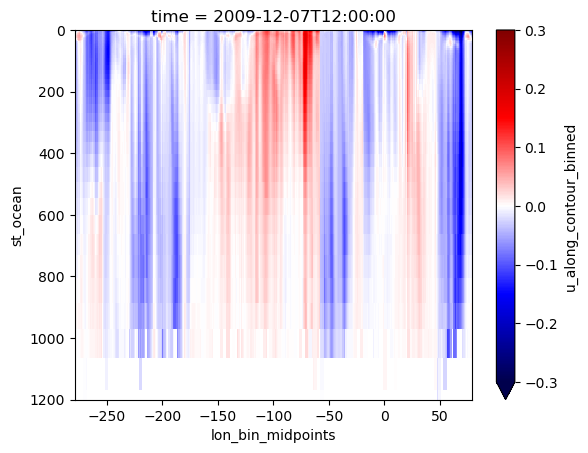

In [49]:
#random time index for testing
Tind = randint(0,u_along_binned_fine_z.time.count().values)

u_along_binned_fine_z.u_along_contour_binned.isel(time=Tind).plot(vmin=-.3,vmax=.3,cmap='seismic')
plt.ylim(1200,0)


In [5]:
# binning monthly in ρ coords
u_along_unbinned_fine_ρ_monthly = u_along_unbinned_fine_ρ.resample(time='1M').mean()
# binning yearly in ρ coords
u_along_unbinned_fine_ρ_yearly = u_along_unbinned_fine_ρ.resample(time='1Y').mean()


In [6]:
#volumes for averaging at some point
Volume_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')

In [7]:
#volume timeseries
volume_percentage = xr.open_dataset('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/percentage_of_CDW.nc')



In [8]:
# Load CSHT field
CSHT_ρ_10d_daily = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})
CSHT_ρ_10d_noZC_daily = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})
# resample monthly:
CSHT_ρ_10d_monthly = CSHT_ρ_10d_daily.resample(time='1M').mean()
CSHT_ρ_10d_noZC_monthly = CSHT_ρ_10d_noZC_daily.resample(time='1M').mean()

In [9]:
# monthly water mass mask 
age_mask_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [11]:
# Daily age mask
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')

In [13]:
vol_bins_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')

In [16]:
n_bins = len(vol_bins_monthly.lon_bins)

### Layerwise correlations in each density bin

In [174]:
import sys
import numpy
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
numpy.set_printoptions(threshold=sys.maxsize)

In [23]:
u_along_10d_ρ_monthly.load()
print('loading monthly U for fast correlations')

loading monthly U for fast correlations


In [33]:
#calculating monthly layerwise correlation
monthly_layerwise_correlations_ρ = xr.corr(u_along_10d_ρ_monthly.U,\
                                           CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned,dim = 'time').compute()
monthly_layerwise_r2s_ρ = (xr.corr(u_along_10d_ρ_monthly.U,\
                                           CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned,dim = 'time')**2).compute()

# monthly slopes
monthly_layerwise_cov_ρ = xr.cov(u_along_10d_ρ_monthly.U, \
                                 CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned, dim="time")
monthly_layerwise_var_ρ = CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned.var(dim='time')
monthly_layerwise_slopes_ρ = (monthly_layerwise_cov_ρ/monthly_layerwise_var_ρ).compute()
monthly_layerwise_slopes_ρ = 1e-12*(1/monthly_layerwise_slopes_ρ) #reverse to be TW/m/s

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/publi

In [290]:
#calculating daily climatology layerwise correlation
##daily cliamtology of CSHT
CSHT_ρ_10d_daily_clim = CSHT_ρ_10d_daily.groupby('time.dayofyear').mean() # CSHT_ZC_lon_binned
# #
clim_layerwise_correlations_ρ = xr.corr(u_along_10d_ρ_daily_clim.ASCspeed,\
                                           CSHT_ρ_10d_daily_clim.CSHT_ZC_lon_binned,dim = 'dayofyear').compute()
clim_layerwise_r2_ρ = (xr.corr(u_along_10d_ρ_daily_clim.ASCspeed,\
                                           CSHT_ρ_10d_daily_clim.CSHT_ZC_lon_binned,dim = 'dayofyear')**2).compute()



# daily slopes slopes
clim_layerwise_cov_ρ = xr.cov(u_along_10d_ρ_daily_clim.ASCspeed, \
                                 CSHT_ρ_10d_daily_clim.CSHT_ZC_lon_binned, dim='dayofyear')
clim_layerwise_var_ρ = CSHT_ρ_10d_daily_clim.CSHT_ZC_lon_binned.var(dim='dayofyear')
clim_layerwise_slopes_ρ = (clim_layerwise_cov_ρ/clim_layerwise_var_ρ).compute()
clim_layerwise_slopes_ρ = 1e-12*(1/clim_layerwise_slopes_ρ) #reverse to be TW/m/s

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/pu

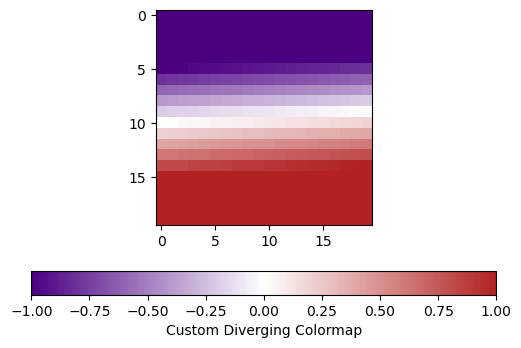

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap
colors = ["indigo", "white", "firebrick"]  # Negative, Zero, Positive
experimental_cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=256)

# Create a normalization that centers white at 0
divnorm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Test the colormap with a sample plot
x = np.linspace(-2, 2, 400).reshape(20, 20)  # Sample data
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(x, cmap=experimental_cmap, norm=divnorm)

# Add a colorbar
cbar = plt.colorbar(img, ax=ax, orientation="horizontal")
cbar.set_label("Custom Diverging Colormap")

plt.show()

In [217]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    #original_cmap = cmocean.curl
    original_cmap = experimental_cmap

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))
    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.000001*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white
    
    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [146]:
n=11
base = plt.cm.get_cmap(cmocean.dense)
color_list = base(np.linspace(0, 1, N))
cmap_name = base.name + str(N)
discrete_dense = base.from_list(cmap_name, color_list, N)

In [195]:
#CDWpresence
CDW_presence = age_mask_monthly.CDW_mask.fillna(0).sum('time')
CDW_presence_fillna = age_mask_monthly.CDW_mask.count('time')
CDW_presence_ratio = 100* CDW_presence/CDW_presence_fillna
CDW_presence_ratio =CDW_presence_ratio.where(CDW_presence_ratio>0).compute()
#AASW
AASW_presence = age_mask_monthly.AASW_mask.fillna(0).sum('time')
AASW_presence_fillna = age_mask_monthly.AASW_mask.count('time')
AASW_presence_ratio = 100* AASW_presence/AASW_presence_fillna
AASW_presence_ratio =AASW_presence_ratio.where(AASW_presence_ratio>0).compute()

Text(0.5, 1.0, '[d] Climatology layerwise slopes ')

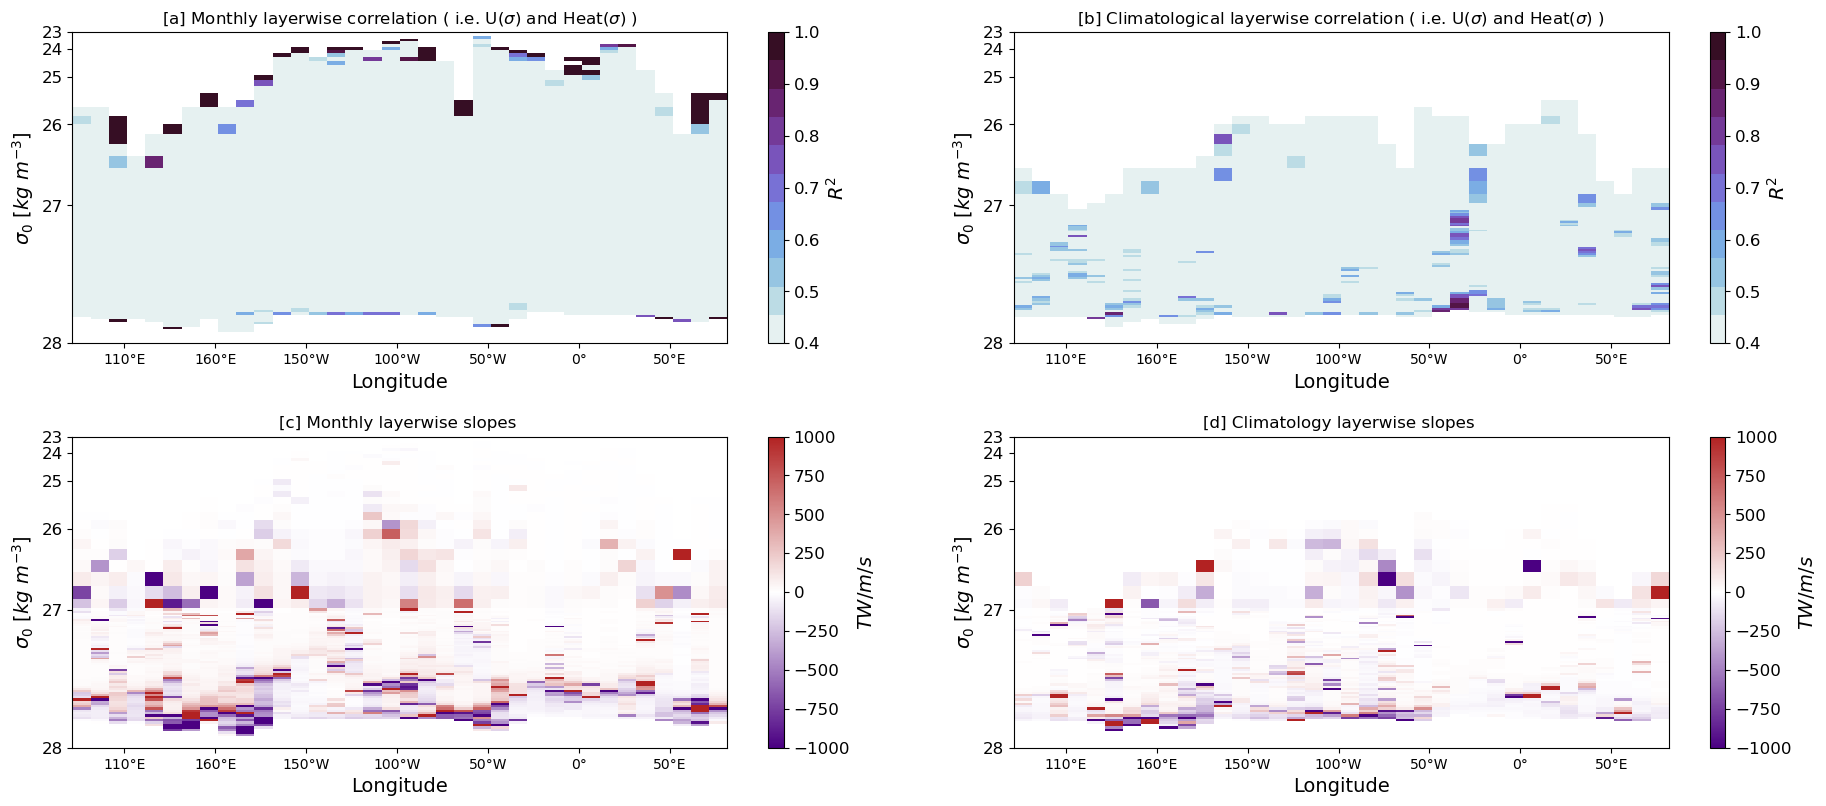

In [420]:
#conversor of vertical coordiantes
def warp(y):
    return 1.7**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(3,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
               monthly_layerwise_r2s_ρ,cmap=discrete_dense,vmin=0.4,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R^2$', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[a] Monthly layerwise correlation ( i.e. U($\sigma$) and Heat($\sigma$) )')



#climatology correlations
ax01 = fig.add_subplot(3,2,2)
plt.pcolormesh(clim_layerwise_r2_ρ.lon_bins,warp(clim_layerwise_r2_ρ.potrho0),\
               clim_layerwise_r2_ρ,cmap=discrete_dense,vmin=0.4,vmax=1)

ax01.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax01.set_ylim(warp(28),warp(23))
cbar01 = plt.colorbar()
cbar01.ax.tick_params(labelsize=12)
cbar01.set_label(label=r'$R^2$', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax01.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[b] Climatological layerwise correlation ( i.e. U($\sigma$) and Heat($\sigma$) )')


#monthly slopes
ax1 = fig.add_subplot(3,2,3) #custom_curl_cmap()
plt.pcolormesh(monthly_layerwise_slopes_ρ.lon_bins,warp(monthly_layerwise_slopes_ρ.potrho0),\
               monthly_layerwise_slopes_ρ,cmap=custom_curl_cmap(),vmin=-1000,vmax=1000)
ax1.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax1.set_ylim(warp(28),warp(23))
cbar1 = plt.colorbar()
cbar1.ax.tick_params(labelsize=12)
cbar1.set_label(label=r'$TW/m/s$', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[c] Monthly layerwise slopes ')




#monthly slopes
ax11 = fig.add_subplot(3,2,4) #custom_curl_cmap()
plt.pcolormesh(clim_layerwise_slopes_ρ.lon_bins,warp(clim_layerwise_slopes_ρ.potrho0),\
               clim_layerwise_slopes_ρ,cmap=custom_curl_cmap(),vmin=-1000,vmax=1000)
ax11.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax11.set_ylim(warp(28),warp(23))
cbar11 = plt.colorbar()
cbar11.ax.tick_params(labelsize=12)
cbar11.set_label(label=r'$TW/m/s$', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax11.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[d] Climatology layerwise slopes ')


why does daily data doesn't have lighter bins?


How many of these layerwise slopes are above 0.5?


In [302]:
percentage_monthlybins_above05 = 100 * (1 + monthly_layerwise_r2s_ρ.where(monthly_layerwise_r2s_ρ>=0.5)*0).sum()/monthly_layerwise_r2s_ρ.count() #only 3% of the monhtly bins have correlations above 0.5

percentage_climbins_above05 = 100 * (1 + clim_layerwise_r2_ρ.where(clim_layerwise_r2_ρ>=0.5)*0).sum()/clim_layerwise_r2_ρ.count() #only 6% of the climatology bins have correlations above 0.5

percentage_monthlybins_above05,percentage_climbins_above05 

(<xarray.DataArray ()> Size: 8B
 array(2.63059),
 <xarray.DataArray ()> Size: 8B
 array(6.142289))

In [304]:
#separating relevant monthly bins
relevant_monthly_bins = (1 + monthly_layerwise_r2s_ρ.where(monthly_layerwise_r2s_ρ>=0.5)*0)

relevant_monthly_ρbins = relevant_monthly_bins * relevant_monthly_bins.potrho0
relevant_monthly_lonbins = relevant_monthly_bins * relevant_monthly_bins.lon_bins

If we extrace the CSHT in the relevant bins, does it look like the total CSHT? and how much it accounts comapred to teh total CSHT?

In [408]:
CSHT_relevantbins_timeseries = 1e-12 * ((1 + monthly_layerwise_r2s_ρ.where(monthly_layerwise_r2s_ρ>=0.5)*0)*CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned).sum(('potrho0','lon_bins')).compute()
CSHT_total_timeseries = 1e-12 * (CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned).sum(('potrho0','lon_bins')).compute()
CSHT_total_ρ = 1e-12 * (CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned).sum(('lon_bins')).mean('time').compute()

Text(0.5, 0, 'Heat transport (neg = poleward) [$TW$]')

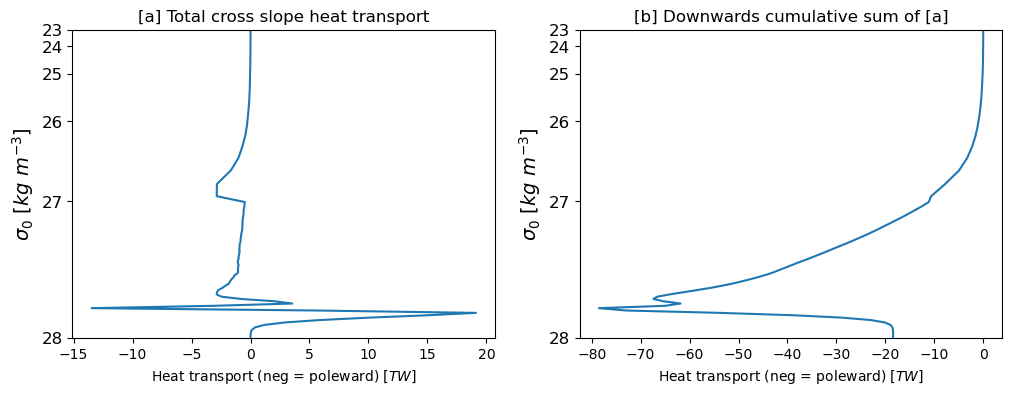

In [417]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(CSHT_total_ρ,warp(CSHT_total_ρ.potrho0))
plt.yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
plt.ylim(warp(28),warp(23))
plt.title('[a] Total cross slope heat transport')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
plt.xlabel(r'Heat transport (neg = poleward) [$TW$]')

plt.subplot(1,2,2)
plt.plot(CSHT_total_ρ.cumsum(),warp(CSHT_total_ρ.potrho0))
plt.yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
plt.ylim(warp(28),warp(23))
plt.title('[b] Downwards cumulative sum of [a]')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
plt.xlabel(r'Heat transport (neg = poleward) [$TW$]')

Text(0.5, 0, 'longitude')

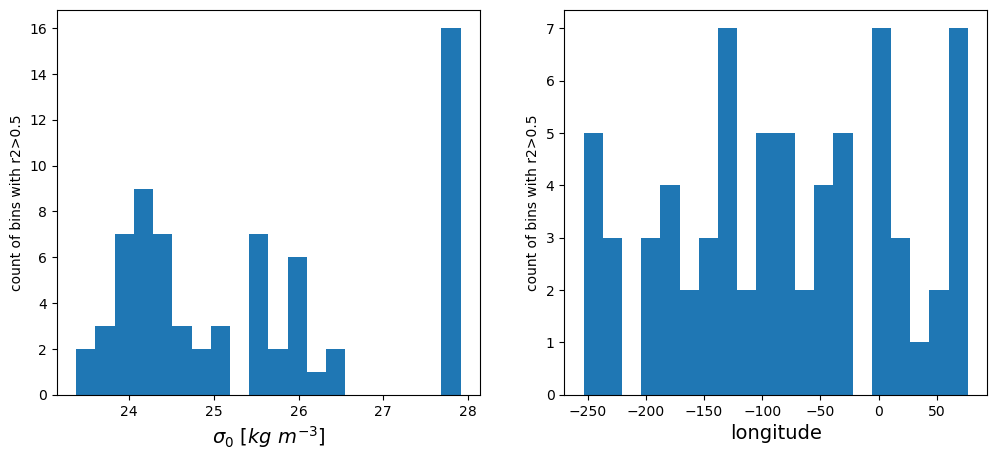

In [316]:

fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
relevant_monthly_ρbins.plot.hist(bins=20)
plt.ylabel('count of bins with r2>0.5')
plt.xlabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)

plt.subplot(1,2,2)
relevant_monthly_lonbins.plot.hist(bins=20)
plt.ylabel('count of bins with r2>0.5')
plt.xlabel(r'longitude',fontsize = 14)

Above we can see that just very light densities asociates with surface waters seem to have r2>0.2

### Correlations between surface speeds and total CSHT

In [343]:
#obtaining surface speeds from density layers - monthly
u_monthly_mask = 1 +( u_along_10d_ρ_monthly.U *0)
u_monthly_potrho = u_monthly_mask * u_monthly_mask.potrho0 
u_monthly_minpotrho = u_monthly_potrho.min('potrho0') #minimum density each timestep with exhisting bin

u_monthly_surface = u_along_10d_ρ_monthly.U.sel(potrho0 = u_monthly_minpotrho).drop('potrho0') #surface velocity

#obtaining surface speeds from density layers - climatology
u_clim_mask = 1 +( u_along_10d_ρ_daily_clim.ASCspeed *0)
u_clim_potrho = u_clim_mask * u_clim_mask.potrho0 
u_clim_minpotrho = u_clim_potrho.min('potrho0') #minimum density each timestep with exhisting bin
u_clim_surface = u_along_10d_ρ_daily_clim.ASCspeed.sel(potrho0 = u_clim_minpotrho).drop('potrho0') #surface velocity

In [350]:
#integrating the 
CSHT_ρ_10d_monthly_vertical_integral = CSHT_ρ_10d_monthly.CSHT_ZC_lon_binned.sum('potrho0').compute()
CSHT_ρ_10d_daily_clim_vertical_integral = CSHT_ρ_10d_daily_clim.CSHT_ZC_lon_binned.sum('potrho0').compute()

In [357]:
#calculating monthly correlation between surface ASC and vertically integrated CSHT
monthly_surf_correlations_ρ = xr.corr(u_monthly_surface,\
                                           CSHT_ρ_10d_monthly_vertical_integral,dim = 'time').compute()
monthly_surf_r2s_ρ = (xr.corr(u_monthly_surface,\
                                           CSHT_ρ_10d_monthly_vertical_integral,dim = 'time')**2).compute()

# monthly slopes
monthly_surf_cov_ρ = xr.cov(u_monthly_surface, \
                                 CSHT_ρ_10d_monthly_vertical_integral, dim="time")
monthly_surf_var_ρ = CSHT_ρ_10d_monthly_vertical_integral.var(dim='time')
monthly_surf_slopes_ρ = (monthly_surf_cov_ρ/monthly_surf_var_ρ).compute()
monthly_surf_slopes_ρ = 1e-12*(1/monthly_surf_slopes_ρ) #reverse to be TW/m/s

Text(0.5, 1.0, '[c] Monthly slopes with surface ASC ( i.e. U(surf) and $\\int _{z} Heat$ )')

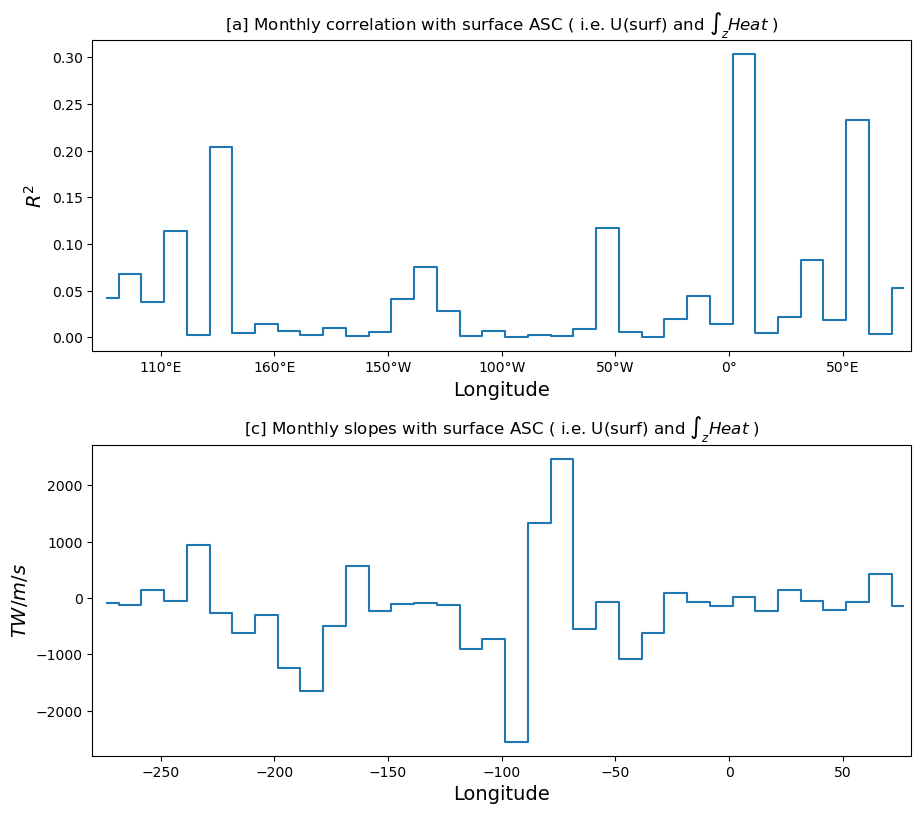

In [374]:
fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(3,2,1)
monthly_surf_r2s_ρ.plot.step(where='mid')
plt.xlim(-280,80)
plt.ylabel(r'$R^2$',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[a] Monthly correlation with surface ASC ( i.e. U(surf) and $\int _{z} Heat$ )')


ax1 = fig.add_subplot(3,2,3)
monthly_surf_slopes_ρ.plot.step(where='mid')
plt.xlim(-280,80)
plt.ylabel(r'$TW/m/s$',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[c] Monthly slopes with surface ASC ( i.e. U(surf) and $\int _{z} Heat$ )')